In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


# Poisson problem (Dirichlet)
$$\nabla^2 u = f(x, y)$$
The 5-point Laplacian is used at interior grid points. This system of equations is then solved using `solve`.

In [2]:
import scipy.sparse as sparse
from scipy.sparse import linalg as spla
# Adapted from  http://www.amath.washington.edu/~rjl/fdmbook/chapter3  (2007)
a = 0.
b = 1.
m = 20
h = (b - a)/(m + 1)
x = linspace(a, b, m+2)   # grid points x including boundaries
y = linspace(a, b, m+2)   # grid points y including boundaries


X, Y = meshgrid(x, y)      # 2d arrays of x, y values
X = X.T                    # transpose so that X(i, j), Y(i, j) are
Y = Y.T                    # coordinates of (i, j) point

Xint = X[1:-1, 1:-1]       # interior points
Yint = Y[1:-1, 1:-1]

def f(x, y):
    return 1.25*exp(x + y/2.)

rhs = f(Xint, Yint)        # evaluate f at interior points for right hand side
                           # rhs is modified below for boundary conditions.

utrue = exp(X + Y/2.)      # true solution for test problem

# set boundary conditions around edges of usoln array:

usoln = utrue.copy()        # use true solution for this test problem
                            # This sets full array, but only boundary values
                            # are used below.  For a problem where utrue
                            # is not known, would have to set each edge of
                            # usoln to the desired Dirichlet boundary values.


# adjust the rhs to include boundary terms:
rhs[:, 0] = rhs[:, 0] - usoln[1:-1, 0]/h**2
rhs[:, m-1] = rhs[:, m-1] - usoln[1:-1, m+1]/h**2
rhs[0, :] = rhs[0, :] - usoln[0, 1:-1]/h**2
rhs[m-1, :] = rhs[m-1, :] - usoln[m+1, 1:-1]/h**2


# convert the 2d grid function rhs into a column vector for rhs of system:
F = rhs.flatten()

# form matrix A:
I = sparse.eye(m)
e = ones(m)
T = sparse.spdiags([e, -4*e, e], [-1, 0, 1], m, m)
S = sparse.spdiags([e, e], [-1, 1], m, m)
A = (sparse.kron(I, T) + sparse.kron(S, I)) / h**2


# Solve the linear system:
uvec = spla.spsolve(A, F)

# reshape vector solution uvec as a grid function and 
# insert this interior solution into usoln for plotting purposes:
# (recall boundary conditions in usoln are already set) 

usoln[1:-1, 1:-1] = uvec.reshape(m, m)

# assuming true solution is known and stored in utrue:
err = usoln - utrue
err_max = absolute(err).max()
print('Error relative to true solution of PDE =', err_max)

Error relative to true solution of PDE = 3.273228472711054e-05


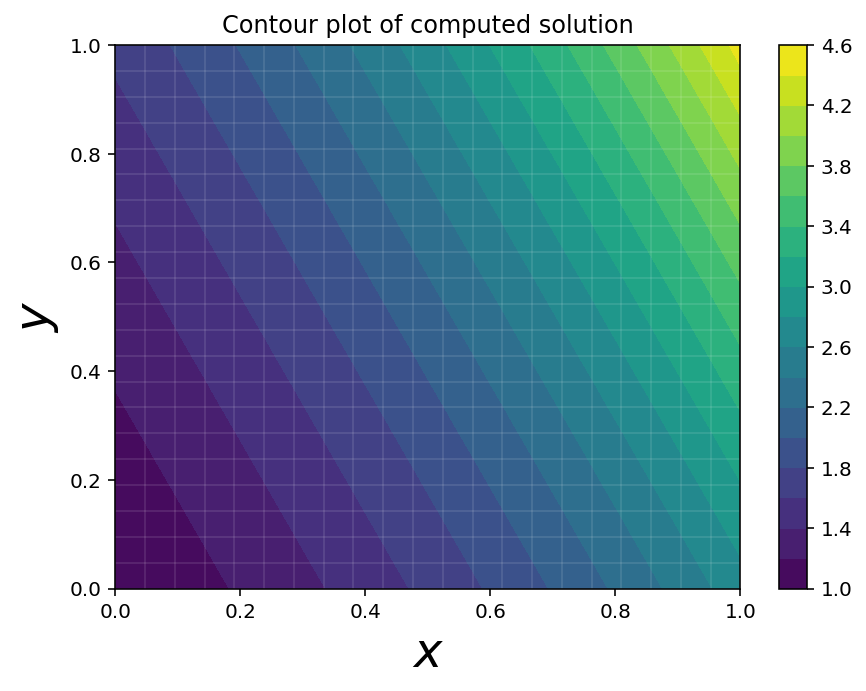

In [3]:
# plot results:
fig = figure(1, [7, 5])

# plot grid:
plot(X, Y, 'w', lw=0.1)
plot(X.T, Y.T, 'w', lw=0.1)

# plot solution:
contourf(X, Y, usoln, 20)
colorbar()

xlim(a, b)
ylim(a, b)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);
title('Contour plot of computed solution');

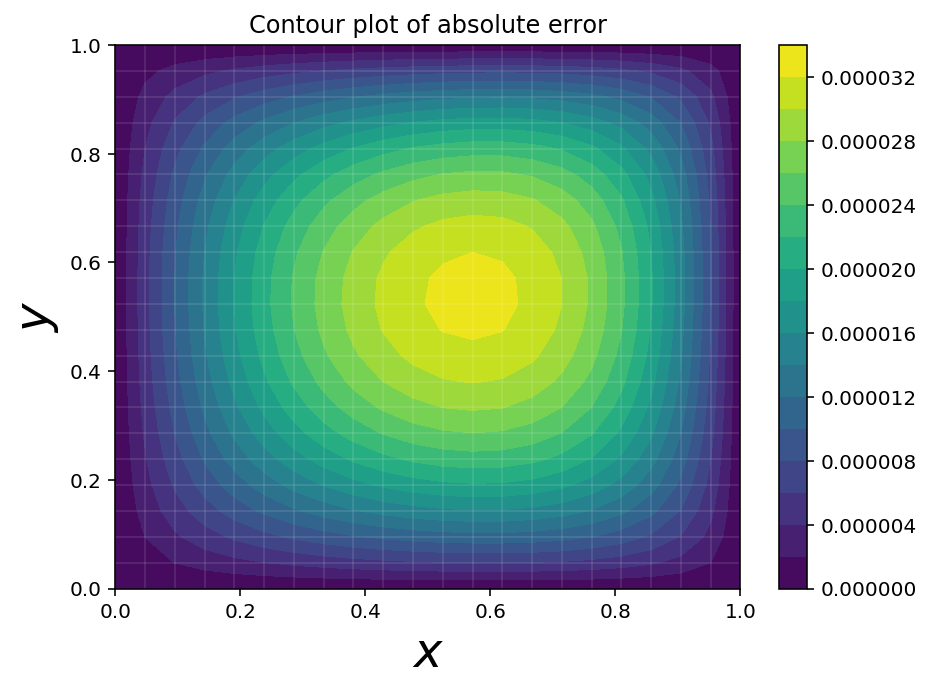

In [4]:
# plot error
fig = figure(1, [7, 5])

# plot grid:
plot(X, Y, 'w', lw=0.1)
plot(X.T, Y.T, 'w', lw=0.1)

# plot solution:
contourf(X, Y, err, 20)
colorbar()

xlim(a, b)
ylim(a, b)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);
title('Contour plot of absolute error');

# Arrays, grids, and matrices
Clearly these are all related concepts. An array is a data structure on a computer. A (2D) grid is a discretized solution to a 2D PDE (elliptic for the purposes of this conversation). A matrix is a mathematical representation of a certain kind of linear operator. The way we notationally use these three things can lead to confusion. 

For example, a grid is written as $U_{ij}$ and the elements of a matrix might be written $a_{ij}$. However, for the grid, the second index moves along the columns of the grid whereas it moves along the rows of a matrix. Why define things this way if it is confusing? I think the reason to define a grid this way is that we want to write $U_{ij} = u(x_i, y_j)$; we naturally want the ordering of the indices to match the independent variables ($i$ first and $j$ second matching $x$ first and $y$ second). We want $x$ to be the horizontal dimension and $y$ to be the virtical dimension. It is simply a convention that conflicts with the way we represent matrices. We could easily write the solution to our PDE as $u(y, x)$, which would make everything consistent, but this is apparently too strange. 

One of the key differences between arrays and matrices is that matrices almost always index starting at $i=1$, $j=1$ (this is not necessary of course, we could index matrices starting from any integer). On the other hand, with the exception of Matlab, virtually every programming language starts indexes into arrays from zero. Grids usually are indexed starting from zero, but this is not as consistent as the convention for matrices.

Matrices are fundamentally two dimensional (ie they have two indices $i, j$) while arrays and grids can by any dimension. Mathematically, we know that the formulation of linear algebra with matrices and vectors is very general and applies to any finite dimensional vector space. In other words, we can always map our $d$ dimensional linear operators to matrices and grids to vectors. We see this in our numerical methods. We might think of the finite difference operator as a 4D operator (with four indices) acting on a 2D grid function (with two indices). However, we convert these into a matrix operator and a vector. We stack each grid row into a single column vector, and we create a 'banded' matrix representing the 2D finite difference operator.

# 'Container' type data structures
Much of the difficulty in coding when it comes to scientific computing—whether it is 'data science' or numerical PDEs—stems from using container type data structurs. The simplest kind is an array. Arrays are so simples because each element is a chunk of data that has the same size (same number of bytes). An array is three things: a starting point in memory (a 'pointer' memory address), the size of each element in bytes, and the total number of elements. To find the $i$th element, you go to the start point in memory and skip ahead by $iS$ bytes, where $S$ is the size of each element. 

This is a **direct access** data structure, meaning that we can read any element we want without reading the preceeding elements (think a casset/VHS tape vs a record). When playing a record, we can place the needle where we want and start playing any song at any point within the song. When playing a casset tape, we have to 'fast forward' or 'rewind' to the spot we want to start playing at.

Arrays can be inconvenient for two reasons:
  1. We need to know the size of the array ahead of time, when we initialize the array, before we can use it
  2. They require every element to have the same number of bytes
  3. Elements that do not contain important information (e.g., a zero value in a sparse array) must occupy space in memory
  
This creates practical constraints that are annoying. For example, this means we cannot add more elements (or remove elements) to an array after it is created. We cannot combine a set of 1D arrays, each having a different length, into a 2D array. If we have a large tridiagonal matrix, with roughly $3n$ nonzero elements, we must reserve enough memory for $n^2$ elements, even though most of these elements are zero and do not need to be stored.

Many other 'container' data structers exist that allow you to dynamically add or remove items (e.g., within in a loop), allow you to have variable size elements and/or elements of different data types. However, there are downsides to each of them if they are not used properly. They are often slower. They often require complicated memory management in the background that can get messed up. Their memory usage might not scale very well with the total number of data elements (in the case of dynamic structures that can be resized after they are created).

The standard language that allows for detailed control over data structures and memory is C++.

In [10]:
N = 10 # number of elements in the array
a = zeros(N, dtype=float64) # an array of zeros, with the optional argument 'dtype' (float64 is the default)
## for a float64, the size of each element in bytes is 8 (8 bits in a byte means 8*8 = 64 bits)
print(a)
a[0] = 1.
a[N-1] = 1.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
## Now what if we try to add an element to the array
a[N] = 2.

IndexError: index 10 is out of bounds for axis 0 with size 10

In [22]:
## Lists are dynamic containers
alist = list(a) ## copy the data from the array into a new list
print(alist)
alist.append(2.) ## add a new element to the end of the array
print(alist)
print(N, a.size, len(alist))

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0]
10 10 11


In [23]:
## other data types
a32 = zeros(N, dtype=float32) ## half the number of bytes (S=2) per element (and half the precision)
a_int64 = zeros(N, dtype=int64) ## 64 bit integers ie integer values in [-2^64/2, 2^64/2] (roughly)
a_uint8 = zeros(N, dtype=uint8) ## 8 bit (1 byte) non negative integers, in [0, 255]

# Sparse arrays in Python
TBD

# Interior layer solutions
 $$ \epsilon u'' + u(u' - 1) = 0, \quad u(0)=\alpha,\; u(1) = \beta$$
 ## Outer solution ($\epsilon=0$)
 $$ u_{\rm out}(x) = x + C $$

In [5]:
epsilon = 0.01
a = 0.
b = 1.
alpha = -1.
beta = 1.5
x = linspace(a, b, 200)
u_outer_a = x - a + alpha
u_outer_b = x - b + beta
A = 0.5*(a - b - (alpha - beta))
C = 0.5*(alpha + beta - (a + b))
u_outer = x + C
xbar = -C

@interact(epsilon=(0.01, 0.1, 0.01))
def plotfn(epsilon=0.1):
    U = A*tanh(A*(x - xbar)/2./epsilon)
    figure(1, [7, 5])
    plot(x, u_outer_a)
    plot(x, u_outer_b)
    plot(x, u_outer + U)
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$u$', fontsize=24);

interactive(children=(FloatSlider(value=0.1, description='epsilon', max=0.1, min=0.01, step=0.01), Output()), …

# Grid mapping function
Start with a uniform grid $z_i$ on $[0, 1]$. Define a *grid mapping function* $X(z): [0, 1] \to [0, 1]$ which should be continuous and strictly increasing with $X(0) = 0$ and $X(1) = 1$ (i.e., a bijection). Then the new grid is given by
    $$x_i = a + (b-a)X(z_i)$$

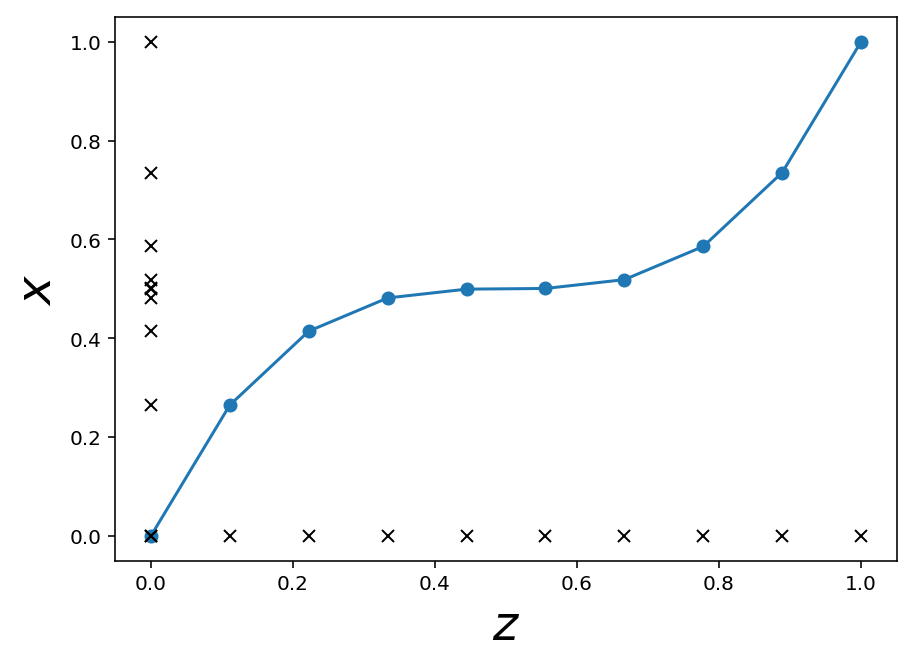

In [49]:
z = linspace(0, 1, 10)

X = 4.*(z - 0.5)**3 + 0.5

figure(1, [7, 5])
plot(z, X, '-o')
plot(z, 0*z, 'xk')
plot(0*X, X, 'xk')
xlabel(r'$z$', fontsize=24)
ylabel(r'$x$', fontsize=24);